Cell 1: Imports & Reproducibility

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

# -------------------------------
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# -------------------------------


Cell 2: Load & Preprocess Data

In [ ]:
# Load CSV
df = pd.read_csv('/content/electricitydemanddata.csv')

# Convert boolean columns to float
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

# Drop non-numeric columns
df = df.drop(columns=['Date', 'Holiday name'])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['Day of the week', 'Month', 'Holiday_cat'], drop_first=True)

# Features and targets
target_cols = [col for col in df.columns if '_demand' in col]
feature_cols = [col for col in df.columns if col not in target_cols]

X = df[feature_cols].values.astype(np.float32)
y = df[target_cols].values.astype(np.float32)

# Scale features and targets separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X = feature_scaler.fit_transform(X)
y = target_scaler.fit_transform(y)


Cell 3: Create Multi-step Dataset

In [ ]:
def create_bilstm_dataset_multioutput(X, y, lookback=21, horizon=2):
    Xs, ys = [], []
    for i in range(lookback, len(X)-horizon+1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

lookback = 21  # 21 days input window
horizon = 2    # 2 days output (48-hour forecast)

X_lstm, y_lstm = create_bilstm_dataset_multioutput(X, y, lookback, horizon)

print("X shape:", X_lstm.shape)
print("y shape:", y_lstm.shape)


X shape: (1828, 21, 51)
y shape: (1828, 2, 9)


Cell 4: Train/Validation/Test Split

In [ ]:
total_samples = len(X_lstm)
train_end = int(total_samples * 0.7)
val_end = int(total_samples * 0.85)

X_train, y_train = X_lstm[:train_end], y_lstm[:train_end]
X_val, y_val = X_lstm[train_end:val_end], y_lstm[train_end:val_end]
X_test, y_test = X_lstm[val_end:], y_lstm[val_end:]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

num_features = X_train.shape[2]
num_targets = y_train.shape[2]


Train: (1279, 21, 51) Validation: (274, 21, 51) Test: (275, 21, 51)


Cell 5: Build BiLSTM Model

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(lookback, num_features)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(horizon * num_targets))  # flattened output

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 21, 128)        │        59,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,778 (397.57 KB)

 Trainable params: 101,778 (397.57 KB)

 Non-trainable params: 0 (0.00 B)

Cell 6: Train BiLSTM Model

In [ ]:
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], horizon*num_targets),
    epochs=50,
    batch_size=32,
    verbose=2
)


Epoch 1/50
40/40 - 7s - 176ms/step - loss: 0.0534
Epoch 2/50
40/40 - 3s - 83ms/step - loss: 0.0201
Epoch 3/50
40/40 - 2s - 42ms/step - loss: 0.0161
Epoch 4/50
40/40 - 1s - 34ms/step - loss: 0.0140
Epoch 5/50
40/40 - 3s - 65ms/step - loss: 0.0127
Epoch 6/50
40/40 - 1s - 35ms/step - loss: 0.0115
Epoch 7/50
40/40 - 3s - 64ms/step - loss: 0.0109
Epoch 8/50
40/40 - 2s - 59ms/step - loss: 0.0104
Epoch 9/50
40/40 - 2s - 41ms/step - loss: 0.0099
Epoch 10/50
40/40 - 2s - 58ms/step - loss: 0.0096
Epoch 11/50
40/40 - 1s - 35ms/step - loss: 0.0086
Epoch 12/50
40/40 - 2s - 62ms/step - loss: 0.0087
Epoch 13/50
40/40 - 3s - 64ms/step - loss: 0.0085
Epoch 14/50
40/40 - 2s - 60ms/step - loss: 0.0082
Epoch 15/50
40/40 - 2s - 41ms/step - loss: 0.0079
Epoch 16/50
40/40 - 2s - 58ms/step - loss: 0.0079
Epoch 17/50
40/40 - 1s - 34ms/step - loss: 0.0075
Epoch 18/50
40/40 - 1s - 35ms/step - loss: 0.0075
Epoch 19/50
40/40 - 1s - 35ms/step - loss: 0.0072
Epoch 20/50
40/40 - 3s - 65ms/step - loss: 0.0074
Epoch 21

Cell 7: Evaluate on Training Set

In [ ]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(y_train.shape[0], horizon, num_targets)

y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, num_targets)).reshape(y_train.shape)
y_train_pred_inv = target_scaler.inverse_transform(y_train_pred.reshape(-1, num_targets)).reshape(y_train_pred.shape)

mae_train = mean_absolute_error(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets))
rmse_train = np.sqrt(mean_squared_error(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets)))
mape_train = np.mean(np.abs((y_train_inv - y_train_pred_inv) / y_train_inv)) * 100
r2_train = r2_score(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets))

print("Train Metrics:")
print(f"MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.2f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
Train Metrics:
MAE: 52.40, RMSE: 91.33, MAPE: 4.70%, R²: 0.89


Cell 8: Evaluate on Validation Set

In [ ]:
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.reshape(y_val.shape[0], horizon, num_targets)

y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, num_targets)).reshape(y_val.shape)
y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, num_targets)).reshape(y_val_pred.shape)

mae_val = mean_absolute_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))
rmse_val = np.sqrt(mean_squared_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets)))
mape_val = np.mean(np.abs((y_val_inv - y_val_pred_inv) / y_val_inv)) * 100
r2_val = r2_score(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))

print("Validation Metrics:")
print(f"MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, MAPE: {mape_val:.2f}%, R²: {r2_val:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Validation Metrics:
MAE: 90.70, RMSE: 158.31, MAPE: 7.37%, R²: 0.71


Cell 9: Evaluate on Test Set

In [ ]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(y_test.shape[0], horizon, num_targets)

y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, num_targets)).reshape(y_test.shape)
y_test_pred_inv = target_scaler.inverse_transform(y_test_pred.reshape(-1, num_targets)).reshape(y_test_pred.shape)

mae_test = mean_absolute_error(y_test_inv.reshape(-1, num_targets), y_test_pred_inv.reshape(-1, num_targets))
rmse_test = np.sqrt(mean_squared_error(y_test_inv.reshape(-1, num_targets), y_test_pred_inv.reshape(-1, num_targets)))
mape_test = np.mean(np.abs((y_test_inv - y_test_pred_inv) / y_test_inv)) * 100
r2_test = r2_score(y_test_inv.reshape(-1, num_targets), y_test_pred_inv.reshape(-1, num_targets))

print("Test Metrics:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Metrics:
MAE: 106.95, RMSE: 175.50, MAPE: 8.35%, R²: 0.59


Cell 10: Plot Example Predictions


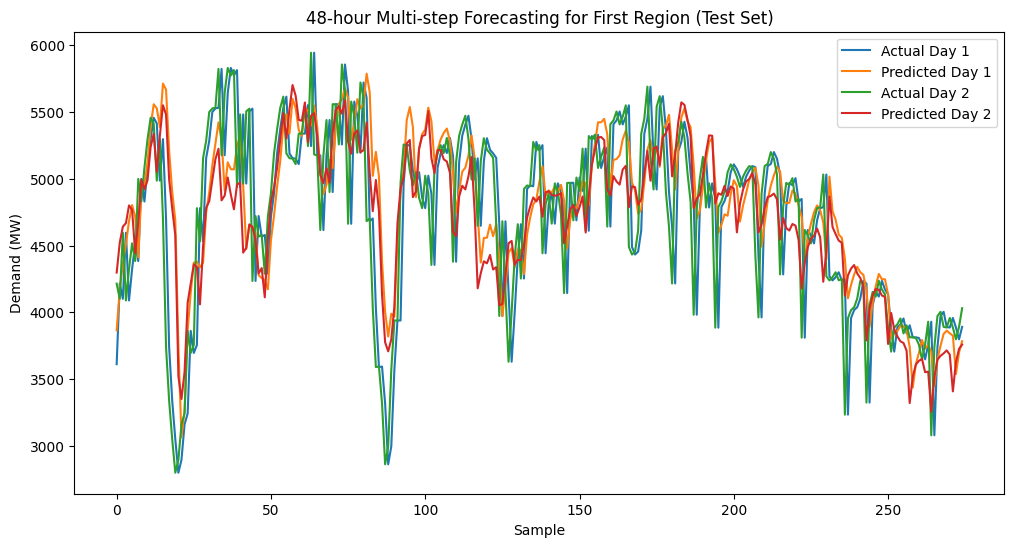

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:,0,0], label='Actual Day 1')
plt.plot(y_test_pred_inv[:,0,0], label='Predicted Day 1')
plt.plot(y_test_inv[:,1,0], label='Actual Day 2')
plt.plot(y_test_pred_inv[:,1,0], label='Predicted Day 2')
plt.legend()
plt.title('48-hour Multi-step Forecasting for First Region (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Demand (MW)')
plt.show()


Cell 1: Define Hyperparameter Ranges and Random Search Settings

In [ ]:
import random

# Hyperparameter ranges
units1_list = [32, 64, 128, 256]
units2_list = [16, 32, 64, 128]
dropout1_list = [0.1, 0.2, 0.3]
dropout2_list = [0.1, 0.2, 0.3]
learning_rate_list = [0.0005, 0.001, 0.005, 0.01]

# Number of random combinations to try
n_iter = 10

best_val_mae = float('inf')
best_params = None
best_model = None
SEED = 42


Cell 2: Random Search Loop

In [ ]:
for _ in range(n_iter):
    # Randomly pick hyperparameters
    units1 = random.choice(units1_list)
    units2 = random.choice(units2_list)
    dropout1 = random.choice(dropout1_list)
    dropout2 = random.choice(dropout2_list)
    lr = random.choice(learning_rate_list)

    # Reproducibility
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Build BiLSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(units1, return_sequences=True), input_shape=(lookback, num_features)))
    model.add(Dropout(dropout1))
    model.add(Bidirectional(LSTM(units2, return_sequences=False)))
    model.add(Dropout(dropout2))
    model.add(Dense(horizon * num_targets))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

    # Train on training set only
    model.fit(
        X_train, y_train.reshape(y_train.shape[0], horizon*num_targets),
        epochs=20, batch_size=32, verbose=0
    )

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    y_val_pred = y_val_pred.reshape(y_val.shape[0], horizon, num_targets)
    y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, num_targets)).reshape(y_val.shape)
    y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, num_targets)).reshape(y_val_pred.shape)

    val_mae = mean_absolute_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))

    print(f"units1:{units1}, units2:{units2}, d1:{dropout1}, d2:{dropout2}, lr:{lr}, val_mae:{val_mae:.2f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_params = (units1, units2, dropout1, dropout2, lr)
        best_model = model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:88.19


Cell 3: Best Hyperparameters

In [ ]:
print("Best Hyperparameters Found (Random Search):")
print(f"units1: {best_params[0]}, units2: {best_params[1]}, dropout1: {best_params[2]}, dropout2: {best_params[3]}, learning_rate: {best_params[4]}")
print(f"Validation MAE: {best_val_mae:.2f}")


Best Hyperparameters Found (Random Search):
units1: 64, units2: 16, dropout1: 0.3, dropout2: 0.1, learning_rate: 0.01
Validation MAE: 88.19


Cell 1: Define Hyperparameter Grid

In [ ]:
# Hyperparameter options
units1_list = [64, 128]
units2_list = [32, 64]
dropout1_list = [0.1, 0.2]
dropout2_list = [0.1, 0.2]
learning_rate_list = [0.001, 0.01]

best_val_mae = float('inf')
best_params = None
best_model = None


Cell 2: Grid Search Loop

In [ ]:
for units1 in units1_list:
    for units2 in units2_list:
        for dropout1 in dropout1_list:
            for dropout2 in dropout2_list:
                for lr in learning_rate_list:

                    # Reproducibility
                    tf.random.set_seed(SEED)
                    np.random.seed(SEED)

                    # Build BiLSTM model
                    model = Sequential()
                    model.add(Bidirectional(LSTM(units1, return_sequences=True), input_shape=(lookback, num_features)))
                    model.add(Dropout(dropout1))
                    model.add(Bidirectional(LSTM(units2, return_sequences=False)))
                    model.add(Dropout(dropout2))
                    model.add(Dense(horizon * num_targets))

                    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

                    # Train only on training set
                    model.fit(
                        X_train, y_train.reshape(y_train.shape[0], horizon*num_targets),
                        epochs=20, batch_size=32, verbose=0
                    )

                    # Evaluate on validation set
                    y_val_pred = model.predict(X_val)
                    y_val_pred = y_val_pred.reshape(y_val.shape[0], horizon, num_targets)
                    y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, num_targets)).reshape(y_val.shape)
                    y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, num_targets)).reshape(y_val_pred.shape)

                    val_mae = mean_absolute_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))

                    print(f"units1:{units1}, units2:{units2}, d1:{dropout1}, d2:{dropout2}, lr:{lr}, val_mae:{val_mae:.2f}")

                    if val_mae < best_val_mae:
                        best_val_mae = val_mae
                        best_params = (units1, units2, dropout1, dropout2, lr)
                        best_model = model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
units1:64, units2:32, d1:0.1, d2:0.1, lr:0.001, val_mae:91.22


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
units1:64, units2:32, d1:0.1, d2:0.1, lr:0.01, val_mae:81.96


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
units1:64, units2:32, d1:0.1, d2:0.2, lr:0.001, val_mae:97.28


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
units1:64, units2:32, d1:0.1, d2:0.2, lr:0.01, val_mae:80.76


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
units1:64, units2:32, d1:0.2, d2:0.1, lr:0.001, val_mae:86.63


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
units1:64, units2:32, d1:0.2, d2:0.1, lr:0.01, val_mae:98.40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
units1:64, units2:32, d1:0.2, d2:0.2, lr:0.001, val_mae:83.38


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
units1:64, units2:32, d1:0.2, d2:0.2, lr:0.01, val_mae:82.39


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
units1:64, units2:64, d1:0.1, d2:0.1, lr:0.001, val_mae:82.04


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
units1:64, units2:64, d1:0.1, d2:0.1, lr:0.01, val_mae:83.53


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
units1:64, units2:64, d1:0.1, d2:0.2, lr:0.001, val_mae:84.58


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
units1:64, units2:64, d1:0.1, d2:0.2, lr:0.01, val_mae:93.95


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
units1:64, units2:64, d1:0.2, d2:0.1, lr:0.001, val_mae:83.00


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
units1:64, units2:64, d1:0.2, d2:0.1, lr:0.01, val_mae:90.50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
units1:64, units2:64, d1:0.2, d2:0.2, lr:0.001, val_mae:88.14


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
units1:64, units2:64, d1:0.2, d2:0.2, lr:0.01, val_mae:84.09


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
units1:128, units2:32, d1:0.1, d2:0.1, lr:0.001, val_mae:85.52


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
units1:128, units2:32, d1:0.1, d2:0.1, lr:0.01, val_mae:78.25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
units1:128, units2:32, d1:0.1, d2:0.2, lr:0.001, val_mae:92.37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
units1:128, units2:32, d1:0.1, d2:0.2, lr:0.01, val_mae:82.00


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
units1:128, units2:32, d1:0.2, d2:0.1, lr:0.001, val_mae:89.63


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
units1:128, units2:32, d1:0.2, d2:0.1, lr:0.01, val_mae:80.01


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
units1:128, units2:32, d1:0.2, d2:0.2, lr:0.001, val_mae:88.38


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
units1:128, units2:32, d1:0.2, d2:0.2, lr:0.01, val_mae:83.02


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
units1:128, units2:64, d1:0.1, d2:0.1, lr:0.001, val_mae:84.13


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
units1:128, units2:64, d1:0.1, d2:0.1, lr:0.01, val_mae:81.33


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
units1:128, units2:64, d1:0.1, d2:0.2, lr:0.001, val_mae:87.56


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
units1:128, units2:64, d1:0.1, d2:0.2, lr:0.01, val_mae:86.35


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
units1:128, units2:64, d1:0.2, d2:0.1, lr:0.001, val_mae:84.05


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
units1:128, units2:64, d1:0.2, d2:0.1, lr:0.01, val_mae:91.20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
units1:128, units2:64, d1:0.2, d2:0.2, lr:0.001, val_mae:83.98


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
units1:128, units2:64, d1:0.2, d2:0.2, lr:0.01, val_mae:88.64


Cell 3: Best Hyperparameters

In [ ]:
print("Best Hyperparameters Found:")
print(f"units1: {best_params[0]}, units2: {best_params[1]}, dropout1: {best_params[2]}, dropout2: {best_params[3]}, learning_rate: {best_params[4]}")
print(f"Validation MAE: {best_val_mae:.2f}")


Best Hyperparameters Found:
units1: 128, units2: 32, dropout1: 0.1, dropout2: 0.1, learning_rate: 0.01
Validation MAE: 78.25
